## 1. Parallel node execution

This module will build on human-in-the-loop as well as the memory concepts discussed in module 2.

We will dive into multi-agent workflows, and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

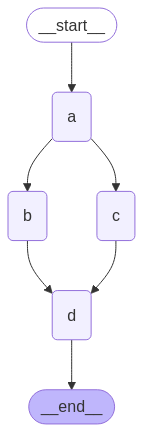

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

# this class act as state of the current graph
class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

# this class make a default node with given node secret
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# build the parallel graph
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

# display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


#### ! If we use fan out we must ensure the reducer is operator.add

When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, operator.add is a function from Python's built-in operator module.

When operator.add is applied to lists, it performs list concatenation.

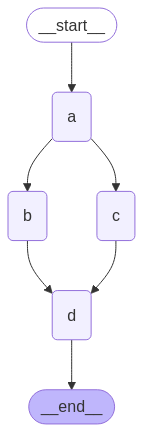

In [ ]:
import operator
from typing import Annotated

# makr the graph with new operator.add method
class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

#### ! Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

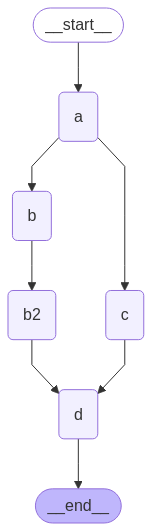

In [6]:
# in fan in way in node is wait until the other nodes are finished their executions
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# invoke the graph using sample empty state
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## 2. Working with LLMs
Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

In [8]:
# this is simple graph state
# context contain the external source result to a specific questions
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

## 3. Sub-graphs

Sub-graphs allow you to create and manage different states in different parts of your graph.

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

- I have a system that accepts logs
- It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
- I want to perform these two operations in two different sub-graphs.
- The most critical thing to understand is how the graphs communicate!

In short, communication is done with over-lapping keys:

- The sub-graphs can access docs from the parent
- The parent can access summary/failure_report from the sub-graphs
